- This file analyzes the impact of dynamically reducing quantity with the goal of keeping delta within a specific limit. This specific run utilizes AAPL Trade from 
`/Users/chiemelienwanisobi/Documents/GitHub/stop-loss-script/BACKTEST/private_backtest/TREND_SYSTEM/BBANDS/WFA/target_opt/results/Return [%]_5Y_reduced_sl.pkl`
Window 10, Index 7 of trades dataframe

In [1]:

from dotenv import load_dotenv
load_dotenv()
import os
import sys
sys.path.append(
    os.environ.get('WORK_DIR')) #type: ignore
sys.path.append(
    os.environ.get('DBASE_DIR')) #type: ignore
from dbase.DataAPI.ThetaData import * #type: ignore
from dbase.database.SQLHelpers import * #type: ignore
import pandas as pd
from EventDriven.data import HistoricTradeDataHandler
from EventDriven.event import *
from queue import Queue
from trade.backtester_.backtester_ import PTDataset, PTBacktester
import pandas_ta as ta
from trade.assets.Stock import Stock
from trade.assets.Calculate import Calculate
from trade.helpers.Context import Context
from trade.assets.helpers.loaders import create_object_from_id
from trade.backtester_.utils.WalkForwardUtils import prev_monday 
from trade.backtester_.strats import BBandsTrend2
from trade.backtester_.strats import MAStrat
import yfinance as yf
import math
from datetime import datetime
from EventDriven.backtest import OptionSignalBacktest
from copy import deepcopy
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
pd.options.display.max_rows = 100
pd.options.display.max_columns = 50
%load_ext autoreload
%autoreload 2


Console Logging & File Logging Can be configured using STREAM_LOG_LEVEL and FILE_LOG_LEVEL in environment variables.
Propagate to root logger can be set using PROPAGATE_TO_ROOT_LOGGER in environment variables.
Example:
STREAM_LOG_LEVEL = 'DEBUG'
FILE_LOG_LEVEL = 'INFO'
PROPAGATE_TO_ROOT_LOGGER = 'False'

2025-03-22 16:17:31 trade.helpers.Logging INFO: Logging Root Directory: /Users/chiemelienwanisobi/cloned_repos/QuantTools/logs
Using Proxy URL: http://18.232.166.224:5500/thetadata


In [2]:
thetadata_start = '2021-01-01'

In [3]:
import json
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
_key = 10
with open(f'../../input/profitable_weights_{_key}.json', 'r') as f:
    weights = json.load(f)
ttrades__ = pd.read_csv(f'../../input/profitable_trades_{_key}.csv').iloc[:, 1:]
ttrades__['Duration'] = ttrades__.Duration.apply(lambda x: int(x.split(' ')[0]))
# AMZN20220329LONG
ttrades__ = ttrades__[(ttrades__.Ticker == 'AAPL') ]
trades_ = ttrades__.copy()
trades_

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
6,66,525,540,148.548104,147.710007,-55.314406,-0.005642,2023-02-03,2023-02-27,24,AAPL
7,63,545,708,154.328258,170.369995,1010.629422,0.103946,2023-03-06,2023-10-26,234,AAPL
13,61,714,752,174.849846,193.899994,1162.059051,0.108951,2023-11-03,2023-12-29,56,AAPL


In [4]:
symbol_list = trades_.Ticker.unique()
untraded_symbols = [s for s in weights.keys() if s not in trades_.Ticker.unique()]
for s in untraded_symbols:
    weights.pop(s)


max_cash = {}
cash = 20_000
for s, w in weights.items():
    if w * cash > 200:
        max_cash[s] = 2
    elif w * cash > 100:
        max_cash[s] = 1
    else:
        max_cash[s] = 0.5
max_cash
pd.Series(weights).sort_values(ascending=False), max_cash

(AAPL    0.118067
 dtype: float64,
 {'AAPL': 2})

In [5]:

# from EventDriven.riskmanager import RiskManager, close_cache, spot_cache, chain_cache, oi_cache, LOOKBACKS, order_cache
# from pandas.tseries.offsets import BDay

# rm = RiskManager(None, None, 1000000)
# rm.OrderPicker.liquidity_threshold = 2
# rm.OrderPicker.lookback = 10
# rm.OrderPicker.data_availability_threshold = 0.15
# date, tick = '2023-07-05', 'AVGO'
# date, tick = '2024-08-13', 'TSM'
# start = (pd.to_datetime(date) - BDay(30)).strftime('%Y-%m-%d')
# right = 'C'
# order_settings = {'type': 'spread',
#  'specifics': [{'direction': 'long',
#    'rel_strike': .50,
#    'dte': 210,
#    'moneyness_width': 0.5},
#   #  {'direction': 'short',
#   # 'rel_strike': .60,
#   # 'dte': 270,
#   # 'moneyness_width': 0.35}
# ],
#  'name': 'vertical_spread'}



# order =  rm.OrderPicker.get_order(tick, date, right, 2, order_settings)
# order

In [6]:
#Backtest class 
## Find a way to not always reinitialize the backtest class, when want to redo

pd.options.display.max_rows = 15
pd.options.display.max_columns = 15

evb_backtest = OptionSignalBacktest(trades_, initial_capital=cash)
evb_backtest.portfolio.initial_capital
w_map = {x: w  * 0.85 for x, w in weights.items()} ## 75% of the weights for each stock
evb_backtest.portfolio.weight_map = w_map
evb_backtest.portfolio.weight_map
evb_backtest.portfolio.risk_manager.OrderPicker.liquidity_threshold = 50
evb_backtest.portfolio.risk_manager.OrderPicker.lookback = 10
evb_backtest.portfolio.risk_manager.OrderPicker.data_availability_threshold = 0.5
evb_backtest.portfolio.order_settings = {'type': 'naked',
 'specifics': [{'direction': 'long',
   'rel_strike': .70,
   'dte': 365,
   'moneyness_width': 0.10},
   {'direction': 'short',
  'rel_strike': .65,
  'dte': 365,
  'moneyness_width': 0.10}
],
 'name': 'vertical_spread'}


evb_backtest.portfolio.max_contract_price = max_cash
evb_backtest.executor.commission_rate = 0.65/100
evb_backtest.portfolio.min_moneyness_threshold = 5
evb_backtest.executor.max_slippage_pct = 0.075
evb_backtest.portfolio.roll_map = 30
evb_backtest.portfolio.moneyness_width_factor = .025
evb_backtest.portfolio.dte_reduction_factor = 30
evb_backtest.portfolio.min_acceptable_dte_threshold = 180
for key  in max_cash:
    if max_cash[key]*100 > evb_backtest.portfolio.allocated_cash_map[key]:
        print(key, max_cash[key]*100, evb_backtest.portfolio.allocated_cash_map[key])



signals = evb_backtest.bars.signal_df
signals_df = deepcopy(signals).set_index('Date')
signals_df[signals_df!=-1].sum().sum()

3.0

## Problems:

- Current Problem: SELL Signal and Buy Signal are put right next to each other in the queue. Whereas, it is meant to be Sell Signal -> Order Event -> Fill Event -> Buy Signal -> Order Event -> Fill Event

Solution:
- Use a tuple of action ```python['CLOSE', 'OPEN']```
- Put first action into queue and return ffunctionality to backtester. Backtester then handles all corresponding sequence.
- Do the same for action two.

In [7]:
import cProfile
import pstats
import io

profiler = cProfile.Profile()
profiler.enable()
#run backtest

evb_backtest.run()
profiler.disable()
stream = io.StringIO()
stats = pstats.Stats(profiler, stream=stream).sort_stats('cumulative')

Processing event: MARKET
Processing event: SIGNAL
Saving to cache from db
Buy Details
Position: {'long': ['AAPL20240119C210'], 'short': ['AAPL20240119C245'], 'trade_id': '&L:AAPL20240119C210&S:AAPL20240119C245', 'close': 1.8950000000000002}, Date: 2023-02-03, Signal: SignalEvent type:LONG, symbol=AAPL, date:2023-02-03 00:00:00, Order Settings=None,Max Contract Price:None , signal_id:AAPL20230203LONG
Max Contract Price: 2, Cash at Hand: 18.064280162209553
Cash at Hand 18.064280162209553 Close 1.8950000000000002
Processing event: ORDER
Buy Order Position: {'long': ['AAPL20240119C210'], 'short': ['AAPL20240119C245'], 'trade_id': '&L:AAPL20240119C210&S:AAPL20240119C245', 'close': 1.8950000000000002} Price: 1.940974881610104 Quantity: 9 Datetime: 2023-02-03 00:00:00
Processing event: FILL
Using If statement for last event
Event queue is empty, processed 4 event(s)
Processing event: MARKET
Using If statement for last event
Event queue is empty, processed 1 event(s)
Processing event: MARKET
U

## ***VISUALIZE TEST RESULTS***

In [8]:
##Transaction details

pd.set_option('display.max_rows', 100)
print(_key)
transactions=evb_backtest.portfolio.transactions
transactions[transactions.symbol=='AAPL']

10


,signal_id,datetime,symbol,direction,cash_before,cash_after
0,AAPL20230203LONG,2023-02-03,AAPL,BUY,2007.142240,248.564847
1,AAPL20230203LONG,2023-02-27,AAPL,SELL,248.564847,1323.812817
2,AAPL20230306LONG,2023-03-06,AAPL,BUY,1323.812817,238.663452
3,AAPL20230306LONG,2023-10-26,AAPL,SELL,238.663452,732.458945
4,AAPL20231103LONG,2023-11-03,AAPL,BUY,732.458945,157.041327
5,AAPL20231103LONG,2023-12-29,AAPL,SELL,157.041327,971.818869


In [33]:
##Trade details
trades = evb_backtest.portfolio._trades.copy()#
len(trades)
preferred_cols = ['Positions','EntryTime', 'ExitTime','Ticker','PnL', 'ReturnPct', 'EntryPrice', 'ExitPrice', 'EntryMarketValue', 'ExitMarketValue',  'EntryPrice', 'ExitPrice', 'Quantity', 'SignalID', 'Duration']
trades[preferred_cols]

,Positions,EntryTime,ExitTime,Ticker,PnL,ReturnPct,EntryPrice,ExitPrice,EntryMarketValue,ExitMarketValue,EntryPrice,ExitPrice,Quantity,SignalID,Duration
0,&L:AAPL20240119C210&S:AAPL20240119C245,2023-02-03,2023-02-27,AAPL,-683.329423,-0.388569,195.397488,119.471997,1746.877393,1086.947971,195.397488,119.471997,9,AAPL20230203LONG,24
1,&L:AAPL20240315C200&S:AAPL20240315C210,2023-03-06,2023-10-26,AAPL,-591.353872,-0.544952,180.858228,82.299249,1077.349366,501.595493,180.858228,82.299249,6,AAPL20230306LONG,234
2,&L:AAPL20240920C230&S:AAPL20240920C265,2023-11-03,2023-12-29,AAPL,239.359924,0.415976,191.805873,271.592514,571.517618,818.677542,191.805873,271.592514,3,AAPL20231103LONG,56


In [10]:
reasons = {
    x['reason']:0 for x in evb_backtest.portfolio.unprocessed_signals
}

for v in (evb_backtest.portfolio.unprocessed_signals):
    reasons[v['reason']] += 1
    print(v) 
reasons

{}

<Axes: xlabel='datetime'>

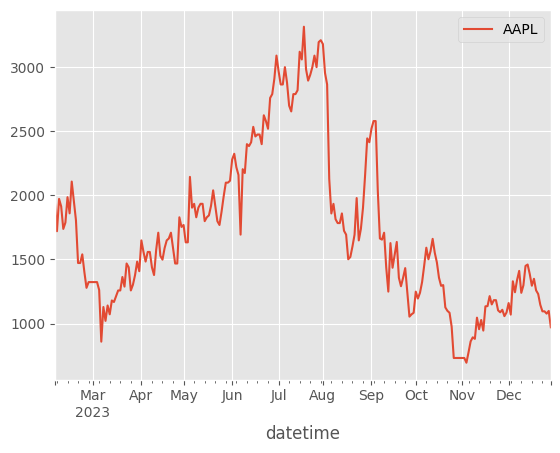

In [11]:
# evb_backtest.portfolio._equity.plot(y = 'COST'), evb_backtest.portfolio._equity.plot(y = 'AAPL'), evb_backtest.portfolio._equity.plot(y = 'NVDA')
# for col in evb_backtest.portfolio._equity.columns:
#     if col not in ['cash', 'Total']:
#         evb_backtest.portfolio._equity.plot(y = col)
#         plt.show()
evb_backtest.portfolio._equity.plot(y = 'AAPL')

In [12]:
evb_backtest.portfolio.plot_portfolio()

In [13]:
evb_backtest.portfolio.aggregate()

Start                                                    2023-02-03 00:00:00
End                                                      2023-12-29 00:00:00
Duration                                                   329 days 00:00:00
Exposure Time [%]                                                      96.19
Equity Final [$]                                                    18964.68
Equity Peak [$]                                                 21306.521211
Return [%]                                                         -4.924298
Buy & Hold Return [%]                                              24.614886
CAGR [%]                                                           -5.448189
Volatility Ann. [%]                                                12.443389
Sharpe Ratio                                                       -0.388091
Sortino Ratio                                                      -0.516461
Skew                                                                 -0.3304

## ***ANALYZE POSITIONS***

In [14]:
create_object_from_id?
Calculate.attribution?

Signature:
Calculate.attribution(
    asset,
    ts_start=None,
    ts_end=None,
    ts_timeframe='day',
    ts_timewidth='1',
    method='GB',
    replace='partial',
    return_both_data=False,
    **kwargs,
)
Docstring:
Calculate attribution of option asset 

Parameter:
____________
ts_start (str | Datetime): Start date if timeseries
ts_end (str | Datetime): End date if timeseries  
ts_timewidth (int): Examples 1,2,3,4. The span over the timeframe
ts_timeframe (str): The timeframe for aggregation, eg: Minute, Hour, Day, Month, Week, Year
method (str): Available methods are 'GB' for Greek Based and 'RV' for Revaluation
replace (str): Available options are 'partial', 'close', 'default_fill'. Partial replaces only the missing data, Close uses close data to fill, default_fill uses the default fill for all data
return_both_data (bool): If True. Will return both the PnL Data and Full Data
return_all: specific to OptionStructure. If True, will return all the data for the long and short leg


In [15]:
trades['structure_object'] = trades.apply(lambda x: create_object_from_id(x['Positions'], date = x['ExitTime'].strftime('%Y-%m-%d')), axis=1)

In [16]:
trades[preferred_cols+['structure_object']]
focus_index = 1
focus_object = trades.iloc[focus_index].structure_object
quantity = trades.iloc[focus_index].Quantity
ticker = trades.iloc[focus_index].Ticker
cash_for_tick = w_map[ticker] * 20_000
focus_start, focus_end = trades.iloc[focus_index].EntryTime.strftime('%Y-%m-%d'), trades.iloc[focus_index].ExitTime.strftime('%Y-%m-%d')
with Context(end_date = focus_start):
    tick_on_start = Stock(ticker)
    spot = list(tick_on_start.spot().values())[0]
focus_start, focus_end

('2023-03-06', '2023-10-26')

In [17]:
size_leverage = 4.5
eq_equivalent_size = (math.floor(cash_for_tick/spot)/100) * size_leverage
eq_equivalent_size

0.585

In [18]:
focus_object.greeks?

Signature:
focus_object.greeks(
    greek_type='greek',
    ts_start=None,
    ts_end=None,
    ts_timewidth=None,
    ts_timeframe=None,
    return_all=False,
)
Docstring:
The greeks method returns a timeseries dataframe for greeks based. Only available for BSM model

PARAMS
______
ts (Bool): True to return dataframe timeseries, false to return spot in a dict
ts_start (str|datetime): Start Date
ts_end (str|datetime): End Date
ts_timewidth (str|int): Steps in timeframe
ts_timeframe (str): Target timeframe for series 
greek_type (str): Type of greek to return. Default is 'greek'.
    'greek' returns all greek, while passing 'delta', 'gamma', 'theta', 'vega' returns only the specific greek
return_all (bool): True to return all from each leg, False to return only the aggregate greeks


RETURNS
_________
pd.DataFrame or dict
File:      ~/cloned_repos/QuantTools/trade/assets/OptionStructure.py
Type:      method

In [19]:
long_leg = focus_object.Structure['long'][0]
short_leg = focus_object.Structure['short'][0]

long_attribution = Calculate.attribution(
    asset = long_leg,
    ts_start = focus_start,
    ts_end = focus_end,
    method = 'GB',
    replace = 'default_fill',
    return_both_data = True
)

short_attribution = Calculate.attribution(
    asset = short_leg,
    ts_start = focus_start,
    ts_end = focus_end,
    method = 'GB',
    replace = 'default_fill',
    return_both_data = True
)


attribution_gb = Calculate.attribution(
    asset = focus_object,
    ts_start = focus_start,
    ts_end = focus_end,
    method = 'GB',
    replace = 'default_fill'
) 


attribution = Calculate.attribution(
    asset = focus_object,
    ts_start = focus_start,
    ts_end = focus_end,
    method = 'RV',
replace = 'default_fill'
)

vol_ts = focus_object.vol(
    ts = True,
    ts_start = focus_start,
    ts_end = focus_end
)

greeks = focus_object.greeks(
    ts_start = pd.to_datetime(focus_start) - BDay(1),
    ts_end = focus_end
)


ticker_ob = Stock(ticker)
spot_ts = ticker_ob.spot(ts = True,
                    ts_start= pd.to_datetime(focus_start) - BDay(1),
                    ts_end=focus_end)

In [20]:
long_greeks = long_leg.greeks(
    ts_start = focus_start,
    ts_end = focus_end,
)

short_greeks = short_leg.greeks(
    ts_start = focus_start,
    ts_end = focus_end,
)

In [21]:
long_full_data = long_attribution[0].set_index('Datetime')
long_pnl = long_attribution[1]

short_full_data = short_attribution[0].set_index('Datetime')
short_pnl = short_attribution[1]

## Attribution Func Stock change & Querying Spot Change are the same
## Calculate.attribution calculation on option structure matches with individual option leg calc
if (long_full_data['Stock_Close_Change_Mark'] - spot_ts['close'].diff()).dropna().sum() == 0:
    print('Stock change & Querying Spot Change are the same on long')
else:
    print('Stock change & Querying Spot Change are not the same on long')


if (short_full_data['Stock_Close_Change_Mark'] - spot_ts['close'].diff()).dropna().sum() == 0:
    print('Stock change & Querying Spot Change are the same on short')
else:
    print('Stock change & Querying Spot Change are not the same on short')


if ((long_pnl - short_pnl) - attribution_gb)['Delta_PnL'].sum() == 0:
    print('PnL Attribution on Structure and Individual Legs match')
else:
    print('PnL Attribution on Structure and Individual Legs do not match')

## Greeks on Structure and Individual Legs match
if ((long_greeks - short_greeks) - greeks)['Midpoint_delta'].sum() == 0:
    print('Greeks on Structure and Individual Legs match')
else:
    print('Greeks on Structure and Individual Legs do not match')


if (((greeks['Midpoint_delta'] * 100) * spot_ts['close'].diff()) - ((greeks['Midpoint_delta'] * 100) * short_full_data['Stock_Close_Change_Mark'])).sum() == 0:
    print('Structure Delta * Spot_TS diff == Structure Delta * Stock_Close_Change_Mark')
else:
    print('Structure Delta * Spot_TS diff != Structure Delta * Stock_Close_Change_Mark')


Stock change & Querying Spot Change are the same on long
Stock change & Querying Spot Change are the same on short
PnL Attribution on Structure and Individual Legs match
Greeks on Structure and Individual Legs match
Structure Delta * Spot_TS diff == Structure Delta * Stock_Close_Change_Mark


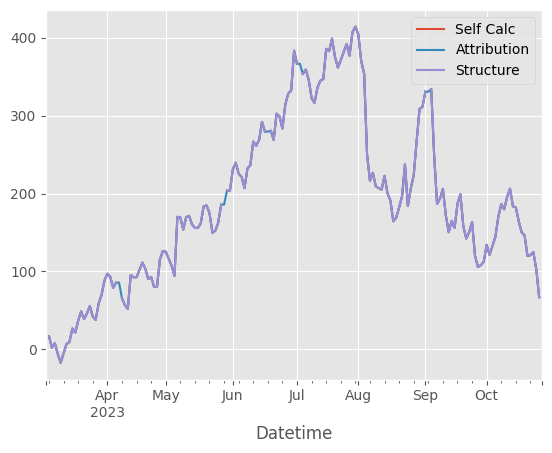

In [22]:
self_calc_pnl = ((long_full_data['Delta'] - short_full_data['Delta'])*100) * spot_ts['close'].diff()
self_calc_pnl.cumsum().plot(label = 'Self Calc'), attribution_gb['Delta_PnL'].cumsum().plot(label = 'Attribution'), (((long_full_data['Delta'] - short_full_data['Delta'])*100) * spot_ts['close'].diff()).cumsum().plot(label = 'Structure')
plt.legend()

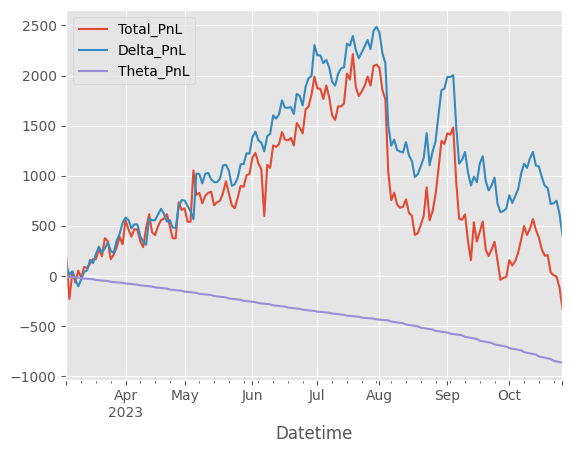

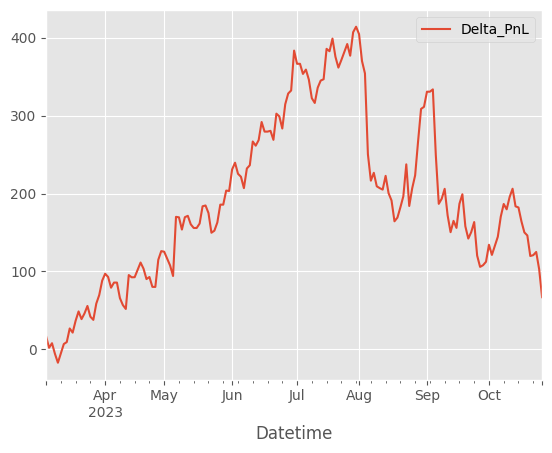

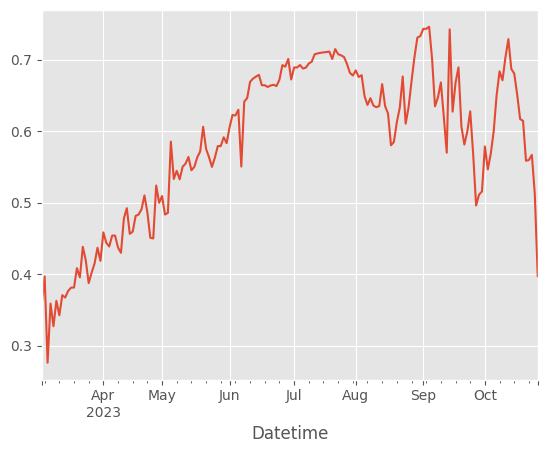

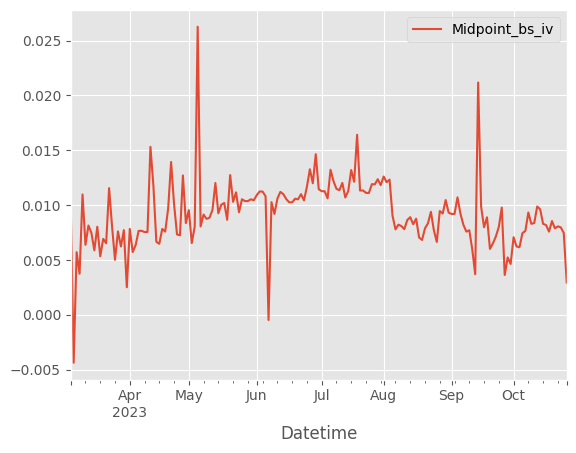

In [23]:


(attribution * quantity).cumsum().plot(y = ['Total_PnL', 'Delta_PnL', 'Theta_PnL'])
plt.show()

(attribution_gb ).cumsum().plot(y = [ 'Delta_PnL'])
plt.show()


(greeks['Midpoint_delta'] *  quantity).plot(y = ['Midpoint_delta']) #spot_ts['close'] *
plt.show()

vol_ts.plot(y = 'Midpoint_bs_iv')
plt.show()

In [24]:
delta = greeks['Midpoint_delta'].shift(1)
quantity_edit = pd.Series(index = delta.index)
booked_quantity = pd.Series(index = delta.index, data = [False]*len(delta)) ## Booked quantity is the quantity that has been booked for the day
q_change = pd.Series(index = delta.index, data = [0]*len(delta)) ## Quantity change for the day
## The plan is to simulate some sort of rebalance, where we want to keep delta within a certain range,
## We plan to achieve this by reducing quantity when delta is too high and increasing quantity when delta is too low
q = quantity
d_threshold = 0.6
d_threshold = eq_equivalent_size
## Start loop
for _delta, index in zip((delta), delta.index):
    day_delta = _delta * q
    if day_delta > d_threshold:
        while day_delta >d_threshold:
            q -= 1
            q_change.loc[index] += 1
            day_delta = _delta * q
        quantity_edit.loc[index] = q
        booked_quantity.loc[index] = True
    else:
        quantity_edit.loc[index] = q

    # print(q)
quantity_edit.sum()

819.0

<Axes: xlabel='Datetime'>

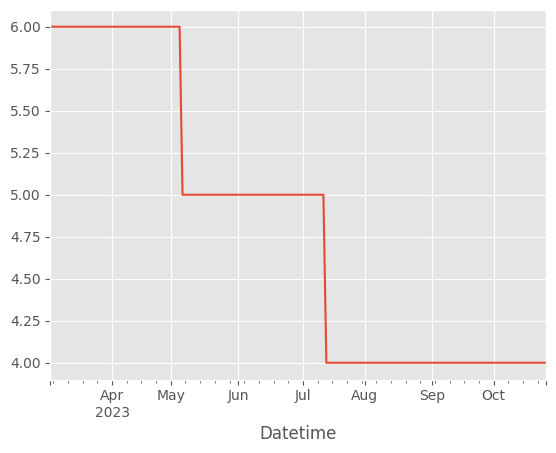

In [25]:
quantity_edit.plot()

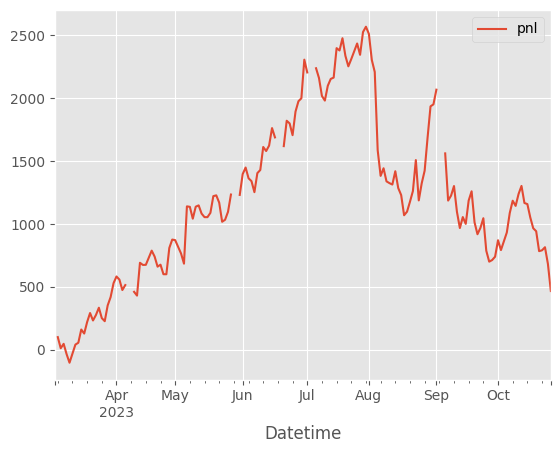

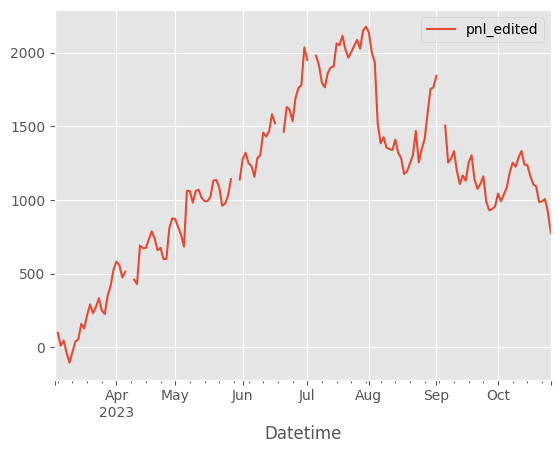

In [26]:
delta = greeks['Midpoint_delta'].shift(1)
quantity_ts = pd.Series([quantity]*len(delta), index = delta.index)
quantity_ts
delta_frame = delta.to_frame()
delta_frame['spot_close'] = spot_ts['close']
delta_frame['unedited_quantity'] = quantity
delta_frame['edited_quantity'] = quantity_edit
delta_frame['close_change'] = delta_frame['spot_close'] - delta_frame['spot_close'].shift(1)
delta_frame['edited_delta'] = (delta_frame['edited_quantity'] * delta_frame['Midpoint_delta']) * 100
delta_frame['unedited_delta'] = (delta_frame['unedited_quantity'] * delta_frame['Midpoint_delta']) * 100
delta_frame['pnl'] = delta_frame['unedited_delta'] * delta_frame['close_change']
delta_frame['pnl_edited'] = delta_frame['edited_delta'] * delta_frame['close_change']
# delta_frame['pnl'].cumsum().plot(y = 'undedited_quantity')
# delta_frame['pnl_edited'].cumsum().plot(y = 'edited_quantity')
# plt.legend()
# plt.show()
# delta_frame.plot(y = ['unedited_delta', 'edited_delta'])
delta_frame.cumsum().plot(y = ['pnl'])
plt.show()
delta_frame.cumsum().plot(y = ['pnl_edited'])
plt.show()

Q Change 1 PnL 133.9030224079591 on 2023-05-05 00:00:00
Q Change 1 PnL 278.86588966446476 on 2023-07-13 00:00:00


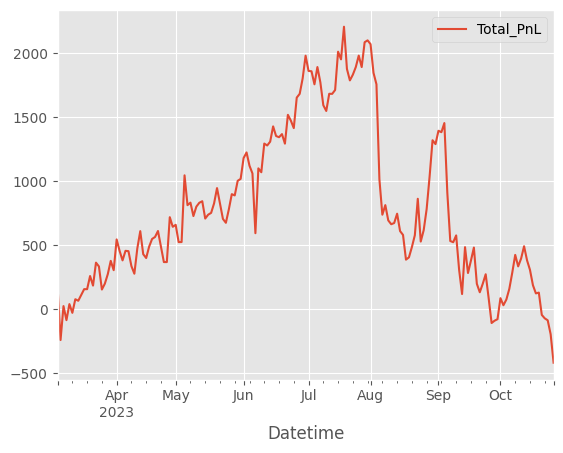

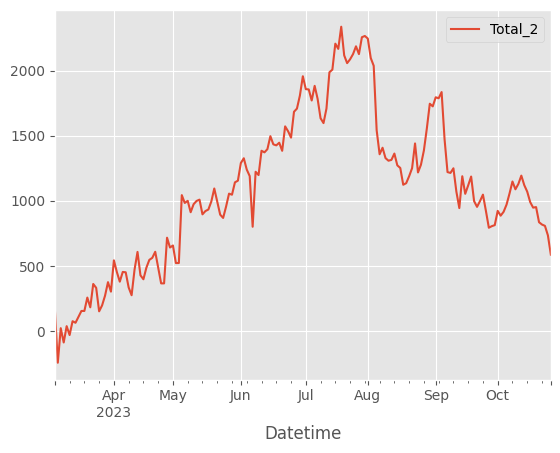

In [27]:
attribution_gb['booked_pnl'] = 0
for date in  booked_quantity[booked_quantity == True].index:
    profit = (attribution_gb.loc[:date, 'Total_PnL'].sum() * q_change.loc[date]) - (q_change.loc[date] * 1.3)
    attribution_gb.loc[date, 'booked_pnl'] = profit
    print(f"Q Change {q_change.loc[date]} PnL {profit} on {date}")
attribution_gb['q2'] = quantity_edit
attribution_gb['Total_2'] = attribution_gb['Total_PnL'] * attribution_gb['q2'] + attribution_gb['booked_pnl']
(attribution_gb * quantity).cumsum().plot(y = 'Total_PnL')
plt.show()
(attribution_gb).cumsum().plot(y = 'Total_2')
plt.show()

In [28]:
attribution_gb.loc[:date, 'Total_PnL'].sum()
booked_quantity[booked_quantity == True].index

DatetimeIndex(['2023-05-05', '2023-07-13'], dtype='datetime64[ns]', name='Datetime', freq=None)

In [29]:
attribution_gb.cumsum()

,Delta_PnL,Gamma_PnL,Theta_PnL,Vega_PnL,Volga_PnL,Vanna_PnL,Rho_PnL,Total_PnL,Unexplained_PnL,Actual_PnL,Price,booked_pnl,q2,Total_2
Datetime,,,,,,,,,,,,,,
2023-03-06,16.707282,0.503498,-1.194477,11.475667,0.107623,0.644112,0.078690,28.322395,0.177605,28.5,170.5,0.000000,6.0,169.934370
2023-03-07,1.954168,0.800617,-1.633975,-43.438635,-2.541441,3.303717,1.097958,-40.457591,1.957591,-38.5,274.0,0.000000,12.0,-242.745548
2023-03-08,7.802457,0.894825,-1.887144,-5.014394,-3.714729,4.325757,1.329720,3.736493,2.763507,6.5,422.5,0.000000,18.0,22.418957
2023-03-09,-5.842217,1.206843,-2.273477,-9.353843,-3.974085,4.615964,1.055365,-14.565451,3.065451,-11.5,553.0,0.000000,24.0,-87.392703
2023-03-10,-17.245375,1.468320,-2.627714,23.799420,-3.049014,3.251987,0.738087,6.335712,2.164288,8.5,703.5,0.000000,30.0,38.014272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-20,119.782886,37.572182,-137.811793,-27.175321,-8.815650,2.331523,6.388644,-7.727529,13.727529,6.0,46244.5,412.768912,797.0,836.150390
2023-10-23,120.900277,37.574608,-140.881830,-29.632724,-8.837233,2.327357,6.347275,-12.202270,13.702270,1.5,46388.0,412.768912,801.0,818.251426
2023-10-24,125.005273,37.608908,-141.925123,-35.249273,-8.867419,2.282199,6.434635,-14.710798,13.710798,-1.0,46529.0,412.768912,805.0,808.217313


In [35]:
attribution_gb.cumsum().Total_2[-1]/cash_for_tick

0.29248067766744823

In [31]:
pnl_calc_delta = attribution_gb['Delta_PnL']




In [32]:
tick, entry, exit = '&L:META20220916C380&S:META20220916C385	2021-11-16	2021-11-29'.split('\t')
_, long, short = tick.split('&')
long, short = long[2:], short[2:] 
price_data = evb_backtest.portfolio.options_data[long] - evb_backtest.portfolio.options_data[short]
price_data.plot(y = 'Midpoint')
price_data[(price_data.index >=entry) & (price_data.index <= exit)]
# price_data#[price_data.index.isin(['2022-01-04', '2022-01-21'])]

KeyError: 'META20220916C380'

In [16]:

long, short 

('META20220916C380', 'META20220916C385')

In [17]:
# COST20240621C550
retrieve_eod_ohlc('COST',
                  '2024-01-15',
                  '2024-06-21',
                  'C',
                  '2023-07-03',
                  560.0,
                  print_url=True)

http://127.0.0.1:25510/v2/hist/option/eod?end_date=20240115&root=COST&use_csv=true&exp=20240621&right=C&start_date=20230703&strike=560000


,Open,High,Low,Close,Volume,Bid_size,CloseBid,Ask_size,CloseAsk,Midpoint,Weighted_midpoint
Datetime,,,,,,,,,,,
2023-07-03,43.23,43.23,43.23,43.23,1,48,42.10,10,45.15,43.625,42.625862
2023-07-03,43.23,43.23,43.23,43.23,1,48,42.10,10,45.15,43.625,42.625862
2023-07-05,43.25,43.32,43.25,43.32,2,16,43.55,10,44.95,44.250,44.088462
2023-07-05,43.25,43.32,43.25,43.32,2,16,43.55,10,44.95,44.250,44.088462
2023-07-06,42.00,43.90,42.00,43.90,4,15,42.30,15,44.40,43.350,43.350000
...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,0.00,0.00,0.00,0.00,0,16,118.25,7,120.70,119.475,118.995652
2024-01-09,0.00,0.00,0.00,0.00,0,21,121.75,31,124.90,123.325,123.627885
2024-01-10,0.00,0.00,0.00,0.00,0,6,125.20,7,132.05,128.625,128.888462


In [18]:
(1.235/1.950)-1

-0.3666666666666666

In [19]:

pd.set_option('display.max_rows', 10000)
evb_backtest.portfolio.get_all_positions()

long                 short  \
datetime   symbol                                              
2021-01-05 AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
           AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
2021-01-06 AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
           AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
2021-01-07 AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
           AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
2021-01-08 AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
           AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
2021-01-11 AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
           AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
2021-01-12 AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
           AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
2021-01-13 AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
           AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
2021-01-14 AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
           AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
2021-01-15 AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
           AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
2021-01-18 AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
           AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
2021-01-19 AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
           AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
2021-01-20 AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
           AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
2021-01-21 AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
           AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
2021-01-22 AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
           NFLX     [NFLX20220121C650]    [NFLX20220121C660]   
           AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
           NFLX     [NFLX20220121C650]    [NFLX20220121C660]   
2021-01-25 AAPL     [AAPL20220121C165]    [AAPL20220121C175]   
           TSLA     [TSLA20220121C920]    [TSLA20220121C930]   
           NFLX     [NFLX20220121C650]    [NFLX20220121C660]   
  

In [20]:


""""
Why do these two return weird stuff after run?
    current_weighted_holdings
    current_positions

I can't reconcile the cost with the data (NVM, haha)

"""
# evb_backtest.portfolio.all_positions

'"\nWhy do these two return weird stuff after run?\n    current_weighted_holdings\n    current_positions\n\nI can\'t reconcile the cost with the data (NVM, haha)\n\n'

## Extend for  get_port_stats
- Buy & Hold
- Dates
- Trades
- _strategy in Aggregate
- The function

In [21]:
evb_backtest.portfolio.trades.to_csv(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/output/profitable_trades_options_{_key}.csv')